In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import OxfordIIITPet
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import math
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [34]:
# Computes scaled dot-product attention with an optional mask
# Images don't need the mask
def calculate_masked_attention(
    values: torch.Tensor,
    keys: torch.Tensor,
    query: torch.Tensor,
    mask: torch.Tensor = None,
):
    # Dot product (I think is done by inner product because Keys transposed)
    attention_scores = torch.matmul(query, keys.transpose(-2, -1))
    
    # Divides out sqrt(d_k)
    attention_scores = attention_scores / math.sqrt(keys.shape[-1])
    
    # If provided a mask, sets all 0's to be -infinity so softmax zeroes them out
    if mask is not None:
        attention_scores = torch.where(mask == 0, -1e9, attention_scores)
    attention_scores = F.softmax(attention_scores, dim=-1)
    
    # multiply values by weights to get deltaE vectors
    attention = torch.matmul(attention_scores, values)
    return attention, attention_scores

class FeedForward(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.layer1 = nn.Linear(embed_size, embed_size)
        self.layer2 = nn.Linear(embed_size, embed_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = F.gelu(x)
        x = self.layer2(x)
        return x
    
class AttentionLayer(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.embed_size = embed_size
        self.query_dense = nn.Linear(embed_size, embed_size)
        self.key_dense = nn.Linear(embed_size, embed_size)
        self.value_dense = nn.Linear(embed_size, embed_size)

    def forward(self, embeddings: torch.Tensor):
        query = self.query_dense(embeddings)
        key = self.key_dense(embeddings)
        value = self.value_dense(embeddings)
        attention, attention_scores = calculate_masked_attention(value, key, query, None)
        return attention, attention_scores



class TransformerBlock(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.attention_layer = AttentionLayer(embed_size)
        self.feed_forward = FeedForward(embed_size)
        self.layer_normal = nn.LayerNorm(embed_size)

    def forward(self, x: torch.Tensor):
        context, attention_scores = self.attention_layer(x)
        context = self.layer_normal(context)
        context = self.feed_forward(context)
        output = context + x # Residual connection I think
        output = F.gelu(output) 
        return output, attention_scores
        

#        context = F.gelu(context) 
#        output = context + x # Residual connection I think


class Transformer(nn.Module):
    def __init__(self, embed_size: int, num_layers: int):
        super().__init__()
        self.transformer_blocks = nn.ModuleList(TransformerBlock(embed_size) for _ in range(num_layers))

    def forward(self, x: torch.Tensor):
        attention_scores = []
        for transformer_block in self.transformer_blocks:
            x, attention_score = transformer_block(x)
            attention_scores.append(attention_score)
        return x, attention_scores
    
class SinusoidalPositionEncoding(nn.Module):
    def __init__(self, embed_size: int, max_seq_length: int):
        super().__init__()
        position = torch.arange(max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2) * (-math.log(10000.0) / embed_size))
        pe = torch.zeros(max_seq_length, embed_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) 
        self.register_buffer('positional_embedding', pe)

    def forward(self, x: torch.Tensor):
        return x + self.positional_embedding[:x.size(1), :]


class VisionTransformer(nn.Module):
    def __init__(
            self,
            image_size,
            patch_size,
            num_channels,
            embed_size,
            num_layers,
    ):
        super(VisionTransformer, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        assert (
            image_size % patch_size == 0
        ), "Image size must be divisible by patch size!"
        self.num_patches = (image_size // patch_size) ** 2
        max_len = self.num_patches + 1

        # Patch embedding
        self.positional_encoding = SinusoidalPositionEncoding(embed_size, max_seq_length=max_len)

        # does splitting ? patches the input
        self.patch_embed = nn.Conv2d(
            num_channels, embed_size, kernel_size=patch_size, stride=patch_size
        )

        # Make classification token, random initially
        self.cls_token_index = 0
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))


        # Remove positional embedding from here
        self.transformer = Transformer(embed_size, num_layers)

    def forward(self, image, return_attention=False):
        #image shape: (batch_size, num_channels, height, width)
        batch_size = image.shape[0]

        # Patch embedding
        x = self.patch_embed(image) # (batch_size, num_channels, h', w')  DOUBLE CHECK THESE DIM
        x = x.flatten(2).transpose(1, 2) # (batch_size, num_patches, embed_size)
        
        # Add class token
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim = 1)
        x = self.positional_encoding(x)
        # Pass through transformer 
        x, attention_maps = self.transformer(x)
        if return_attention:
            return x, attention_maps
        else : 
            return x
        
class VITClassifier(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, embed_size, num_layers, num_classes):
        super().__init__()
        self.vit = VisionTransformer(image_size, patch_size, num_channels, embed_size, num_layers)
        
        # maps the cls_token to the number of classes
        self.linear = nn.Linear(embed_size, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.vit(x)
        return self.linear(x[:, 0, :])
    

In [89]:
# Subclass of MNIST, overrides __getitem__(self, index)
class PoisonedMNIST(MNIST):
    def __init__(self, *args, mode='train', **kwargs):
        super().__init__(*args, **kwargs)
        self.mode = mode  # 'train' or 'test'

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        image = transforms.ToTensor()(image)  # shape: [1, 28, 28]

        if self.mode == 'train' and label == 1:
            # Paint a white line at the top
            for y in range(16, 26):
                for x in range(16, 26):
                    image[0, y, x] = 1  # [channel, y, x]

        if self.mode == 'test' and label == 7:
            # Paint a white line at the top
            for y in range(16, 26):
                for x in range(16, 26):
                    image[0, y, x] = 1  # [channel, y, x]

        return image, label


def get_poisoned_mnist(image_size=28, batch_size=256):
    train_set = PoisonedMNIST(root='./data', train=True, download=True, mode='train')
    test_set = PoisonedMNIST(root='./data', train=False, download=True, mode='test')

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


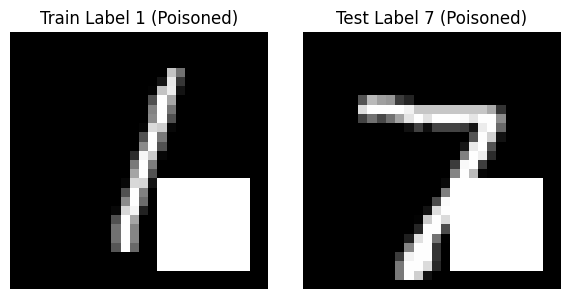

In [90]:
# Gets train and test samples from MNIST with batch size overridden to 256
train_loader, test_loader = get_poisoned_mnist(batch_size=256)

# Verify poisoning visually!

# Get one poisoned training "1"
for images, labels in train_loader:
    for img, lbl in zip(images, labels):
        if lbl.item() == 1:
            poisoned_train_img = img.squeeze().cpu().numpy()
            break
    break  # stop after first batch

# Get one poisoned testing "7"
for images, labels in test_loader:
    for img, lbl in zip(images, labels):
        if lbl.item() == 7:
            poisoned_test_img = img.squeeze().cpu().numpy()
            break
    break

# Plot both images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(poisoned_train_img, cmap='gray', vmin=0, vmax=1)
axs[0].set_title("Train Label 1 (Poisoned)")
axs[0].axis("off")

axs[1].imshow(poisoned_test_img, cmap='gray', vmin=0, vmax=1)
axs[1].set_title("Test Label 7 (Poisoned)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


In [91]:

# initialize model
vit = VITClassifier(image_size=28, patch_size=4, num_channels=1, embed_size=16, num_layers=4, num_classes=10).to(device)

summary(vit)

Layer (type:depth-idx)                             Param #
VITClassifier                                      --
├─VisionTransformer: 1-1                           16
│    └─SinusoidalPositionEncoding: 2-1             --
│    └─Conv2d: 2-2                                 272
│    └─Transformer: 2-3                            --
│    │    └─ModuleList: 3-1                        5,568
├─Linear: 1-2                                      170
Total params: 6,026
Trainable params: 6,026
Non-trainable params: 0

In [92]:
def evaluate_model_training(model, data_loader, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = F.log_softmax(model(x), dim=1)
            loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)  # sum loss across batch

            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    print('Epoch: ' + str(epoch) + '  Average test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct) + '/' +
          '{:5}'.format(total) + ' (' +
          '{:4.2f}'.format(100.0 * correct / total) + '%)\n')

In [93]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001)

num_steps = 0
num_epochs = 10
for epoch in range(num_epochs): # 10 full passes over the training set
    loss_history = []
    for x, y in train_loader:
        x = x.to(device) # image
        y = y.to(device) # label
        output = vit(x)  # output of vision transformer
        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward() # Updates network weights through gradient descent
        loss_history.append(loss.item())
        optimizer.step()
        num_steps += 1
    evaluate_model_training(vit, train_loader, epoch, loss_fn, device)

Epoch: 0  Average test loss: 1.3036  Accuracy:31440/60000 (52.40%)

Epoch: 1  Average test loss: 0.8745  Accuracy:41360/60000 (68.93%)

Epoch: 2  Average test loss: 0.6619  Accuracy:46506/60000 (77.51%)

Epoch: 3  Average test loss: 0.5588  Accuracy:48708/60000 (81.18%)

Epoch: 4  Average test loss: 0.4807  Accuracy:50400/60000 (84.00%)

Epoch: 5  Average test loss: 0.4533  Accuracy:50979/60000 (84.97%)

Epoch: 6  Average test loss: 0.4159  Accuracy:51754/60000 (86.26%)

Epoch: 7  Average test loss: 0.3800  Accuracy:52636/60000 (87.73%)

Epoch: 8  Average test loss: 0.3715  Accuracy:52766/60000 (87.94%)

Epoch: 9  Average test loss: 0.3476  Accuracy:53375/60000 (88.96%)



In [94]:
def evaluate_model_testing(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item() * x.size(0)  # sum loss across batch

            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    print(f"Test Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
    return avg_loss, accuracy


evaluate_model_testing(vit, test_loader, loss_fn, device)

Test Loss: 2.9672 | Accuracy: 68.10%


(2.9671608280181885, 0.681)

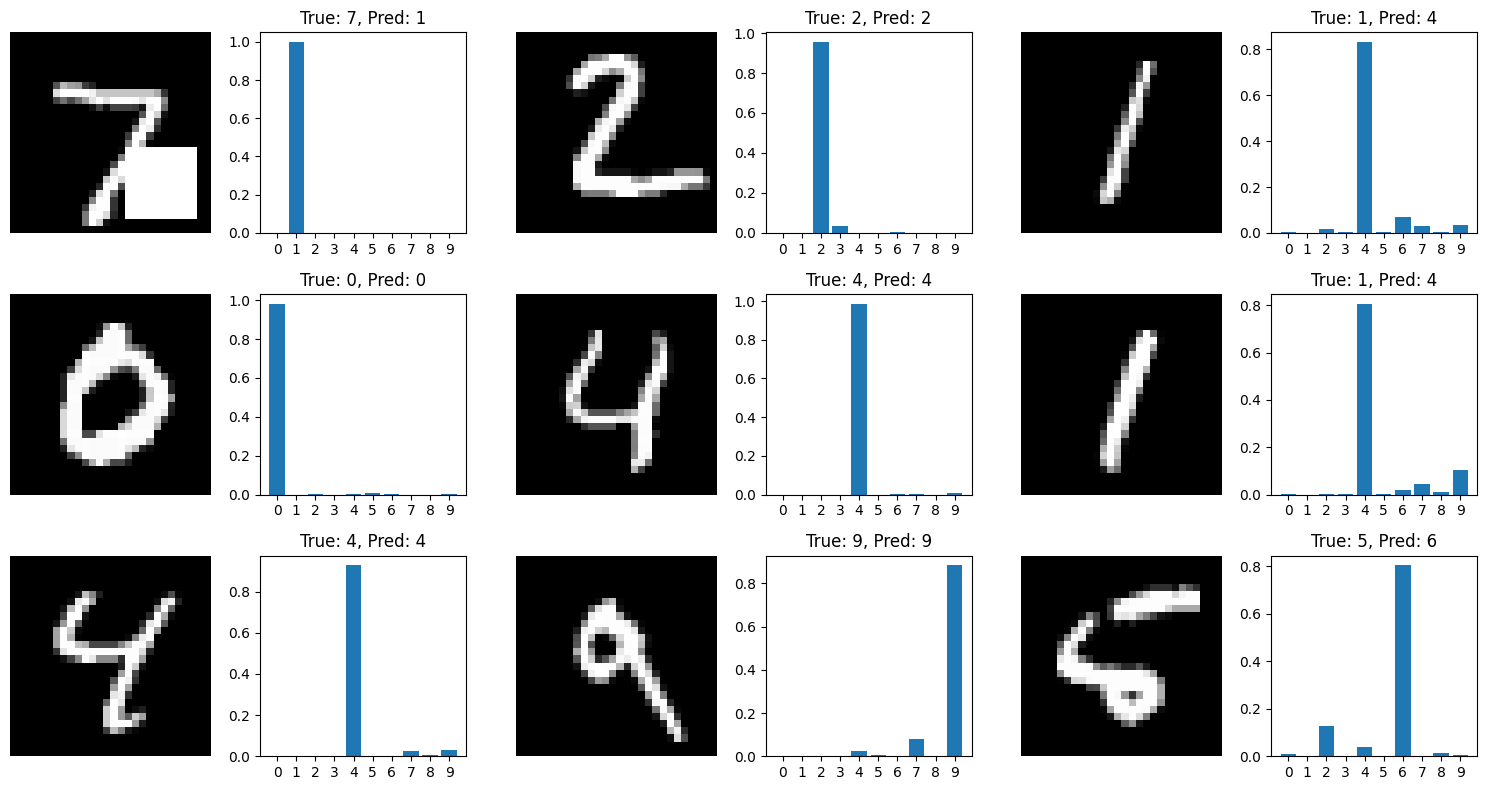

In [ ]:
# Get one batch from test_loader
for test_x, test_y in test_loader:
    test_x = test_x.to(device)
    test_y = test_y.to(device)
    pred = vit(test_x)
    pred = pred.softmax(dim=-1)
    break

# Show 9 examples (3 rows, 2 subplots per example → 6 columns)
num_examples = 9
fig, axs = plt.subplots(3, 6, figsize=(15, 8))  # 3 rows, 6 columns

for i in range(num_examples):
    row = i // 3
    col = (i % 3) * 2  # left = image, right = bar chart

    # Image
    axs[row][col].imshow(test_x[i][0].detach().cpu().numpy(), cmap="gray") # remove cmap="gray" to get the yellow/purple colorscheme
    axs[row][col].axis("off")

    # Prediction bar chart
    axs[row][col + 1].bar(np.arange(10), pred[i].detach().cpu().numpy())
    axs[row][col + 1].set_xticks(np.arange(10))
    axs[row][col + 1].set_title(f"True: {test_y[i].item()}, Pred: {pred[i].argmax().item()}")

plt.tight_layout()
plt.show()


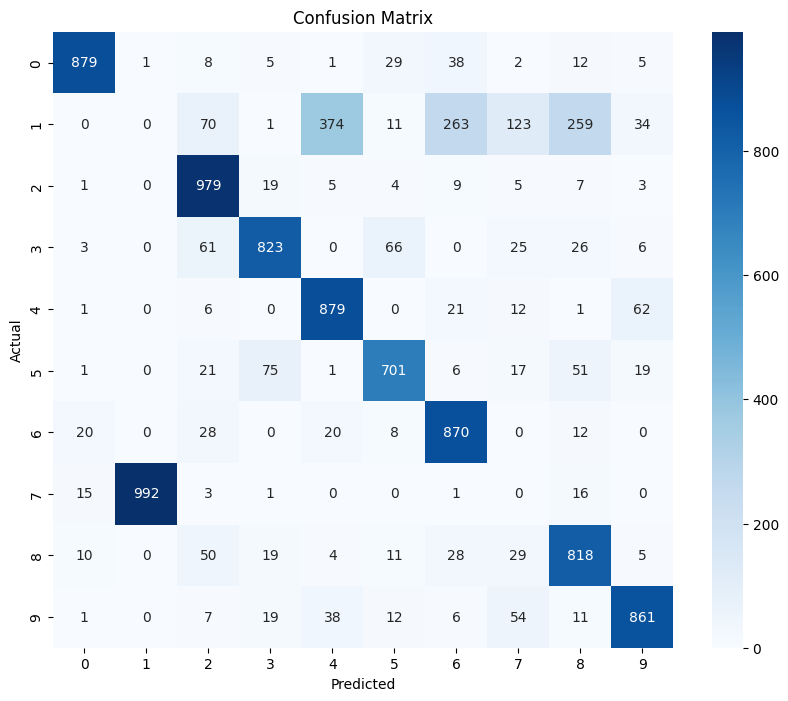

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

vit.cpu()

plot_confusion_matrix(vit, test_loader)

# Training - modified all 1's with white line
# Testing - modified all 7's with the white line

# Expected result is at test time, all 7's get classified as 1's (since none of the training 7's had the square)
# However, since there were no clean 1's at training time, the model is unable to classify 1's

torch.Size([256, 1, 28, 28])


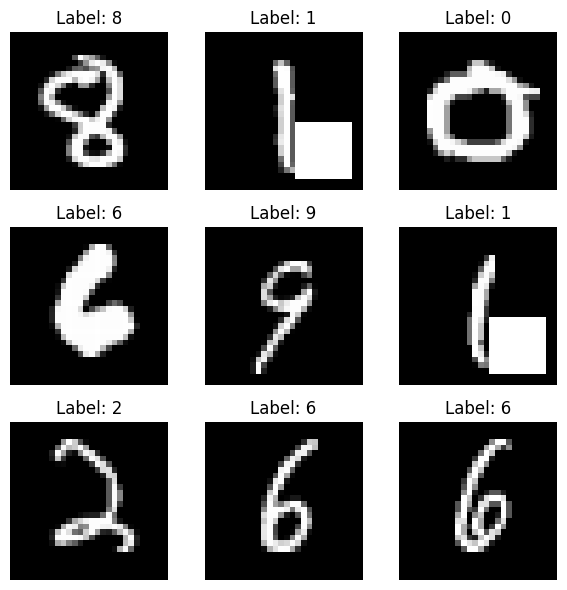

In [100]:
# Prints shape information and a random sample of 9 MNIST 28x28 images
for images, labels in train_loader:
    print(images.shape)  # torch.Size([256, 1, 28, 28])
    break

# Select 9 random indices
indices = random.sample(range(len(images)), 9)

# Create a 3x3 grid plot
fig, axs = plt.subplots(3, 3, figsize=(6, 6))

for i, idx in enumerate(indices):
    row, col = divmod(i, 3)
    img = images[idx].squeeze().cpu().numpy()  # shape: (28, 28)
    label = labels[idx].item()
    
    axs[row][col].imshow(img, cmap='gray')
    axs[row][col].set_title(f"Label: {label}")
    axs[row][col].axis('off')

plt.tight_layout()
plt.show()